<a href="https://colab.research.google.com/github/ThomasHeap/Examples/blob/main/M2L_summer_school/RL/M2L24_RL01%20_Intro_to_RL_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

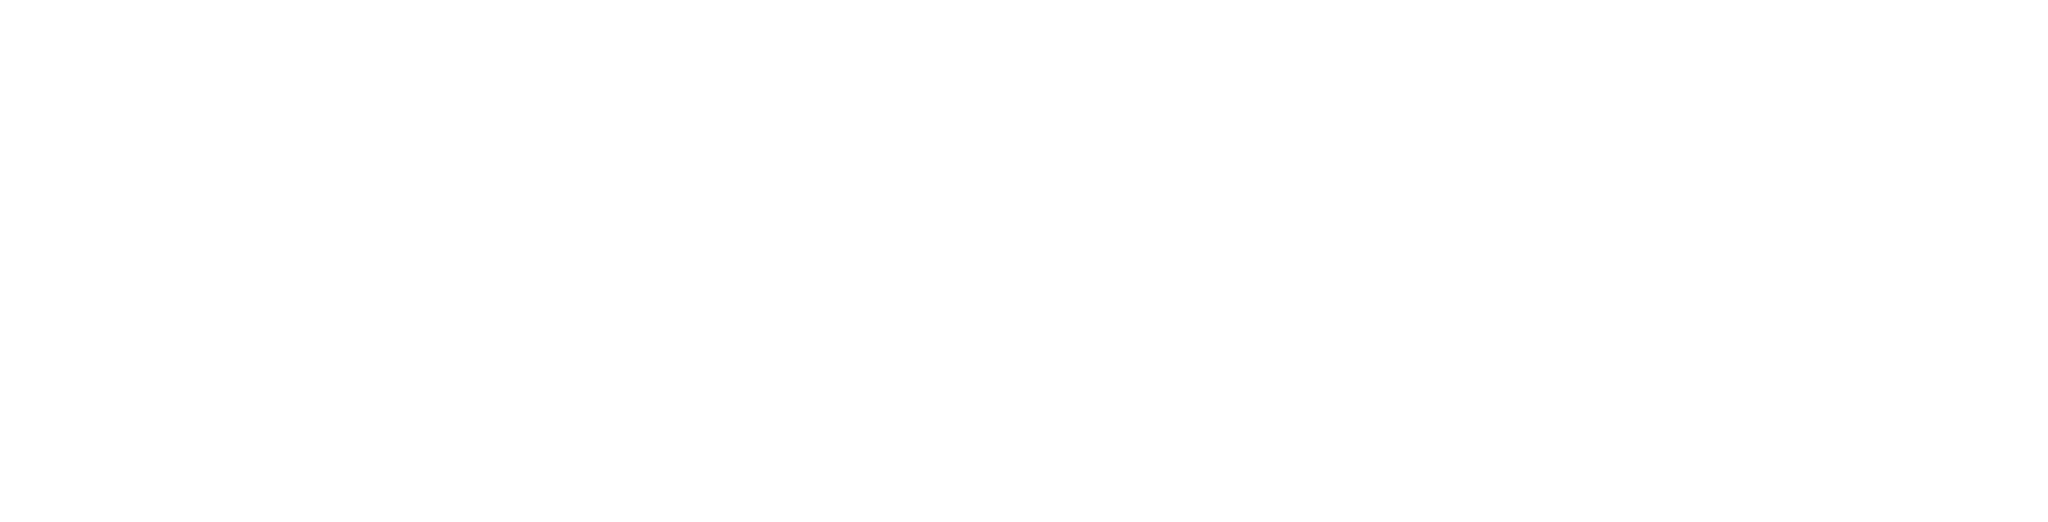

M2L School 2024 Edition, Milan, Italy.

Tutors:

*   Diego Calanzone (diego.calanzone@m2lschool.org)
*   Gianmarco Tedeschi (gianmarco.tedeschi@m2lschool.org)

This tutorial is based on:
*   Explanations and code snippets from the [2023 edition](https://github.com/M2Lschool/tutorials2023/tree/main/5_rl/notebooks/5_1_rl_intro_tabular_q)
*   Custom env. implementation by [Gianmarco Tedeschi](mailto:gianmarco.tedeschi@m2lschool.org)

Notebook author: Diego Calanzone.


---
# RL01: Introduction to Reinforcement Learning
---

In this tutorial, we will be learning about Reinforcement Learning, a type of Machine Learning where an **agent** learns to choose **actions** in an **environment** that lead to maximal **reward** in the long run. RL has seen tremendous success on a wide range of challenging problems such as learning to play complex games like [Atari](https://www.deepmind.com/blog/agent57-outperforming-the-human-atari-benchmark), [StarCraft II](https://www.deepmind.com/blog/alphastar-mastering-the-real-time-strategy-game-starcraft-ii) and [Dota II](https://openai.com/five/) and [Go](https://www.nature.com/articles/nature16961).

Unlike fields like supervised learning, where we give examples of expected behaviour to our models, RL focuses on *goal-orientated* learning from interactions, through trial-and-error. RL algorithms learn what to do (i.e., which actions to take) in an environment to maximise some reward signal. In settings like a video game, the reward signal could be the score of the game, i.e., RL algorithms will try to maximise the score in the game by choosing the best actions.  

<center>
<img src="https://miro.medium.com/max/1400/1*Ews7HaMiSn2l8r70eeIszQ.png" width="40%" />
</center>

[*Image Source*](https://towardsdatascience.com/multi-agent-deep-reinforcement-learning-in-15-lines-of-code-using-pettingzoo-e0b963c0820b)

More precisely, in RL we have an **agent** which perceives an **observation** $o_t$ of the current state $s_t$ of the **environment** and must choose an **action** $a_t$ to take. The environment then transitions to a new state $s_{t+1}$ in response to the agent's action and also gives the agent a scalar reward $r_t$ to indicate how good or bad the chosen action was given the environment's state. The goal in RL is for the agent to maximise the amount of reward it receives from the environment over time. The subscript $t$ is used to indicate the timestep number. In this tutorial we will only consider fully observable games, which means thet state of the environment and observation of the agent are the same.

We will cover the following sections in this tutorial:

* **Environments** where we will either implement a simple environment or use a classical gym environment.
* **Agent-Environment loop** where we will see how agent and environment interact. We will consider the simplest possible agent for this: the agent that just takes a random action at each step.
* **Value-based reinforcement learning** where we will implement an agent that learns from its interactions with the environment which actions to take to achieve the highest reward.

In this colab you will find some

#### ⭐ Exercises
where you need to implement missing parts in the code, or answer the quesions that test your understanding of code and algothims.
When you need to complete some code, the section is marked as:

```
# -----------------------------------#
# You code goes here
# -----------------------------------#
```
with any comments to help you to complete the task. Sometimes it is useful to have a look at further code in the cell to understand which variables you need to assign in your implementation.
Some exercises only require you to answer the questions or experiment with the code.
You can skip bonus exercises if you are short on time as the rest of the content does not depend on them. You can use the Table of content on the left to vavigate the tutorial. Let's begin!


# Environments

In reinforcement learning, we do not start with a dataset, but with an environment. Environments in RL represent the task or problem that we are trying to solve. There are many types of environments, such as board or computer games, simulated robotics settings, etc.

In this tutorial, we will look in details at two simple environments: Minigolf and Cartpole.

In [39]:
%%capture
!pip install gymnasium

In [40]:
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import rc
import seaborn as sns
from tqdm import tqdm
import numpy as np
import random
import torch
import gym

# making plots pretty
sns.set_palette("deep")
rc('animation', html='jshtml')
import warnings
warnings.filterwarnings('ignore')

# for reproducibility's sake!
random.seed(42)
torch.manual_seed(42)
print(gym.__version__)

0.25.2


## Create your own environment

We will firstly see an example of a simple, customized environment created for `gym`. We introduce some theory on the physics of putting (you don't have to focus on this) that will implemented by our environment.

The `Minigolf` environment models a simple problem in which the agent has to hit a ball on grass using a putter in order to reach the hole with the minimum amount of moves.

* The green (grass) is characterized by a **friction** $f$ that is selected uniformly random at the beginning of each episode in the interval `[0.065, 0.196]` and does not change during the episode.
* The **position** of the ball is represented by a unidimensional variable $x_t$ that is initialized uniformly random in the interval `[1,20]`. The observation is made of the pair $s_t = (x_t,f)$.
* The **action** $a_t$ is the force applied to the putter and has to be bounded in the interval `[1e-5,5]`. Before being applied the action is subject to a Gaussian noise, so that the actual action $u_t$ applied is given by:

$$
u_t = a_t + \epsilon \qquad \text{where} \qquad \epsilon \sim \mathcal{N}(0,\sigma^2),
$$
where $\sigma =0.1$. The movement of the ball is governed by the kinematic law:

$$
x_{t+1} = x_{t} - v_t \tau_t + \frac{1}{2} d \tau_t^2
$$

where:
* $v_t$ is the velocity computed as $v_t = u_t l$,
* $d$ is the deceleration computed as $d = \frac{5}{7} fg$,
* $\tau_t$ is the time interval computed as $\tau_t = \frac{v_t}{d}$.

The remaining constants are the putter length $l = 1$ and the gravitational acceleration $g=9.81$. The **episode** terminates when the next state is such that the ball enters or surpasses (without entering) the hole. The **reward** is `-1` at every step and `-100` if the ball surpasses the hole. To check whether the ball will not reach, enter, or surpass the hole, refer to the following condition:

\begin{align*}
&v_t < v_{\min} \implies \text{ball does not reach the hole} \\
&v_t > v_{\max} \implies \text{ball surpasses the hole} \\
&\text{otherwise} \implies \text{ball enters the hole}
\end{align*}

where

\begin{align*}
& v_\min = \sqrt{\frac{10}{7} fgx_t}
& v_\max = \sqrt{ \frac{g(2 h - \rho)^2}{2r} + v_\min^2},
\end{align*}
where $h = 0.1$ is the hole size and $\rho = 0.02135$ is the ball radius.


**References**

Penner, A. R. "The physics of putting." Canadian Journal of Physics 80.2 (2002): 83-96.

### ⭐ Exercise
Skim through the custom Minigolf environment below. Try to fill the blank areas with information from the formulas above. While running the environment, you should notice the first observation value (x position) decreases over time.

In [41]:
import numpy as np
from gymnasium.spaces import Box

class Minigolf(gym.Env):
    """
    The Minigolf problem.

    """

    def __init__(self):
        super(Minigolf, self).__init__()

        # Constants
        self.min_pos, self.max_pos = 1.0, 20.0
        self.min_action, self.max_action = 1e-5, 5.0
        self.min_friction, self.max_friction = 0.065, 0.196
        self.putter_length = 1.0
        self.hole_size = 0.10
        self.sigma_noise = 0.1
        self.ball_radius = 0.02135
        self.gravity = 9.81


        # Instance the spaces
        low = np.array([self.min_pos, self.min_friction])
        high = np.array([self.max_pos, self.max_friction])

        self.action_space = Box(low=self.min_action,
                                high=self.max_action,
                                shape=(1,),
                                dtype=np.float32)

        self.observation_space = Box(low=low,
                                     high=high,
                                     shape=(2,),
                                     dtype=np.float32)


    def step(self, action):

        # Retrieve the state components
        x, friction = self.state

        # Clip the action within the allowed range
        action = torch.clip(
            torch.tensor(action),
            torch.tensor(self.min_action),
            torch.tensor(self.max_action)
        )

        # Add noise to the action
        noisy_action = action + torch.randn(1).item() * self.sigma_noise

        # Compute the speed
        v = noisy_action * self.putter_length
        v = torch.ravel(torch.tensor(v)).item()

        # -----------------------------------#
        # Compute the speed limits v_min, v_max
        # f = friction, g = 9.81, x_t = x
        v_min = torch.sqrt( 10/7 * friction * self.gravity * x)
        v_max = torch.sqrt( (self.gravity * (self.hole_size*2 - self.ball_radius)**2
                             / self.ball_radius) + v_min**2)
        # -----------------------------------#

        # Compute the deceleration
        deceleration = 5 / 7 * friction * 9.81

        # Compute the time interval
        t = v / deceleration

        # Update the state and clip
        x = x - v * t + 0.5 * deceleration * t ** 2
        x = torch.clip(x, self.min_pos, self.max_pos)

        # Compute the reward and episode termination
        reward = 0.
        done = True

        if v < v_min:
            reward = -1.
            done = False
        elif v > v_max:
            reward = -100.

        self.state = torch.tensor([x, friction]).float()

        return self.state, reward, done, False


    def reset(self, seed=None):

        # Random generation of initial position and friction
        # scale [0, 1] to [min, max]
        x = torch.rand(1) * (self.max_pos-self.min_pos) + self.min_pos
        friction = torch.rand(1) * (self.max_friction-self.min_friction) + self.min_friction

        self.state = torch.hstack([x, friction])

        return self.state, {}

Now let's instantiate the custom environment.

In [42]:
# -----------------------------------#
env = Minigolf()
# -----------------------------------#

obs = env.reset()
observation, reward, done, _ = env.step(torch.randn(1))

What do these variables represent?


*   `obs` is Tensor containing the representation of the current state of the environment. In `Minigolf`, this is equivalent to `Tensor([x_position, friction])`.
*   `reward` is returned by the environment.
*   `done` is a boolean variable determining whether the episode (interaction) is over.



### ⭐ Exercise
Let's now write a simple interaction loop:


1.   Reset the environment
2.   While the episode is not over, perform an environment step with a fixed or random action



In [43]:
obs = env.reset()
is_done = False
step = 0
total_reward = 0
while not is_done:
  # -----------------------------------#
  obs, reward, is_done, _ = env.step(torch.randn(1))
  # -----------------------------------#
  print(f"step {step}, obs: {obs}")
  step += 1
  total_reward += reward
print(f"Total reward: {total_reward}")

step 0, obs: tensor([5.8747, 0.1690])
step 1, obs: tensor([3.9328, 0.1690])
step 2, obs: tensor([3.8320, 0.1690])
step 3, obs: tensor([3.6719, 0.1690])
step 4, obs: tensor([3.2977, 0.1690])
step 5, obs: tensor([3.2938, 0.1690])
step 6, obs: tensor([2.4615, 0.1690])
step 7, obs: tensor([2.4592, 0.1690])
step 8, obs: tensor([1.6062, 0.1690])
step 9, obs: tensor([1.6035, 0.1690])
step 10, obs: tensor([1.5687, 0.1690])
step 11, obs: tensor([1.4636, 0.1690])
step 12, obs: tensor([1.4624, 0.1690])
step 13, obs: tensor([1.4602, 0.1690])
step 14, obs: tensor([1.4398, 0.1690])
step 15, obs: tensor([1.4365, 0.1690])
step 16, obs: tensor([1.4295, 0.1690])
step 17, obs: tensor([1.4253, 0.1690])
step 18, obs: tensor([1.3408, 0.1690])
step 19, obs: tensor([1.3402, 0.1690])
step 20, obs: tensor([1.0000, 0.1690])
Total reward: -20.0


We have just introduced a simple, textual environment that can be imported in `gym` to train RL algorithms. We will now overview existing environments with more complex states (numeric, visual).

## Use one of the gym environments

We will use a famous [CartPole](https://gymnasium.farama.org/environments/classic_control/cart_pole/) or inverted pendulum environment.

<center><img src="https://user-images.githubusercontent.com/10624937/42135683-dde5c6f0-7d13-11e8-90b1-8770df3e40cf.gif" height="250" /></center>

From the documentation:

```A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart. The action ... can take values $\{0, 1\}$ indicating the direction of the fixed force the cart is pushed with. The observation ... includes the values corresponding to the following positions and velocities: Cart Position, Cart Velocity, Pole Angle, Pole Angular Velocity. Since the goal is to keep the pole upright for as long as possible, a reward of $+1$ for every step taken, including the termination step, is allotted. At the starting state all observations are assigned a uniformly random value in $(-0.05, 0.05)$.```

Please heck the [documentation](https://gymnasium.farama.org/environments/classic_control/cart_pole/) to see more details about the environment.

In [44]:
# instantiating the environment object
env = gym.make('CartPole-v1', render_mode="rgb_array")

In [45]:
# this resets all env variables and samples the initial state
episode = 0
step = 0
obs = env.reset()

# a in {0, 1}, check: https://www.gymlibrary.dev/environments/classic_control/cart_pole/
action = 0

# get update tuple from the env: (s':List[float], r(s,a):float, terminated:bool, truncated:bool)
obs, reward, terminated, truncated = env.step(action) # this is just ONE step!
step += 1

# one episode goes from the initial state to the ending state
# the environment determines whether you are done with the flags: terminated, truncated
# this follows the game logic, e.g. in CartPole, the stick fell out of the cart.
is_episode_done = truncated or terminated

print(f"""
+===================+
Episode:\t{episode}
Step:\t\t{step}
Is done:\t{is_episode_done}
Reward:\t\t{reward}
+===================+
""")


+===================+
Episode:	0
Step:		1
Is done:	False
Reward:		1.0
+===================+



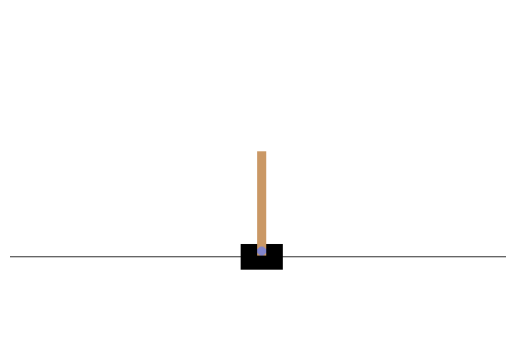

In [46]:
plt.axis("off")
plt.imshow(env.render()[-1])

# Agent-Environment loop
We now turn to the agent. An agent receives the current **state** from the environment, and uses an internal **policy** to determine an **action** to take. We implement the agent as a Python [class](https://en.wikibooks.org/wiki/A_Beginner%27s_Python_Tutorial/Classes), which is just a logical wrapper of variables and methods (functions) that operate on those variables. The methods our first agent will have are the following:


* ```__init__```:  Initialises the agent the first time it's created.
* `action_step`: Receives the observation from the environment and returns an action.



## Random Agent

To get a feel for an agent and the methods it has, let's first implement an agent that ignores the observations and just takes a *random* action at every step: for example, for CartPole it decides to go right or left with equal probability.

### ⭐ Exercise
Now it is your turn to create:

*   An **agent function** or class that given the observation, it **picks and returns an action** among the acceptable ones. Right now you don't have to implement any logic: generate **random** values with PyTorch and remember that gym accepts default python types (float, list).
*   A double agent-env **interaction loop**: iterate through a defined number of episodes, thus create an inner loop to run through the **episode steps** as the game is not done yet.

Your interaction loop should be part of the function `evaluate_policy` and it should return a list of episode rewards (you can sum all the step rewards within an episode).

To show interactions between the agent and the environment in the form of animations, you can create an array of rgb frames with the line: `frames.append(env.render(mode="rgb_array"))`.



In [47]:
from abc import ABC, abstractmethod

class Policy(ABC):
    @abstractmethod
    def action_step(self):
        pass
    @abstractmethod
    def learner_step(self):
        pass

In [48]:
n_actions = env.action_space.n
n_actions

2

In [49]:
class RandomPolicy(Policy):
  def action_step(self, obs):
    # -----------------------------------#
    # sample a random number in the range of n_actions
    return np.random.randint(n_actions)
    # -----------------------------------#
  def learner_step(self,):
    pass # no learning involved at the moment

In [50]:
# @title Utility functions to evaluate policies
def evaluate_policy(policy, num_episodes):
  all_episode_rewards = []
  progressbar = tqdm(range(num_episodes))
  for i in progressbar: # iterate over the episodes
    episode_rewards = []
    done = False
    obs = env.reset()
    frames = []
    while not done: # iterate over the steps until termination
        action = policy.action_step(obs)
        obs, reward, terminated, _ = env.step(action)
        done = terminated
        episode_rewards.append(reward) # compute discounted reward
        try:
          frame = env.render(mode="rgb_array")
          frames.append(frame)
        except:pass
    all_episode_rewards.append(sum(episode_rewards))
  return all_episode_rewards, frames

def plot_rewards(rewards, avg_window_size=10):
  plt.clf()
  moving_avg_rewards = torch.tensor(rewards).unfold(dimension=0, size=avg_window_size, step=1).mean(dim=0)
  plt.plot(range(moving_avg_rewards.shape[0]), moving_avg_rewards.tolist())
  plt.xlabel("Episodes")
  plt.ylabel("Reward")
  plt.grid()
  plt.show()

def animate(data, interval=200):
  fig = plt.figure(1)
  img = plt.imshow(data[0][0])
  plt.axis('off')

  def animate(i):
    img.set_data(data[i][0])

  anim = animation.FuncAnimation(fig, animate, frames=len(data), interval=interval)
  plt.close(1)
  return anim

In [51]:
num_episodes = 100 # @param
random_policy_rewards, frames = evaluate_policy(
    policy=RandomPolicy(), num_episodes=num_episodes)

100%|██████████| 100/100 [00:09<00:00, 10.51it/s]


In [52]:
eval_random_policy_rwd = torch.tensor(random_policy_rewards).mean()
print(f"Average evaluation reward: {eval_random_policy_rwd}")

Average evaluation reward: 20.700000762939453


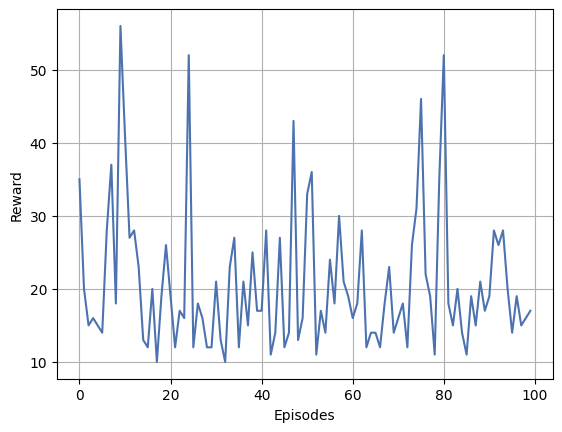

In [53]:
plot_rewards(random_policy_rewards, 100)

We can finally render one episode of agent-environment interaction. Does the agent manage to keep the pole in balance?

In [54]:
animate(frames)

# Value-Based Reinforcement Learning

Not surprisingly, our random agent is not really good at this game and we need to use some learning.

In **value-based** reinforcement learning methods, agents maintain a **value** for all **state-action** pairs. A **value** of a **state-action** pair is telling us what reward to expect if we start at this **state**, take this action and afterwards follow a policy. Then, we use these **value** estimates to choose actions that maximise the value.


## Q-learning

One efficient algorithm for value-based learning is [Q-learning](https://en.wikipedia.org/wiki/Q-learning).
The function that mapping state-action pairs to values for a specific policy $\pi$ is called **Q-function**.
Formally, **Q-function** is defined as:

$$ Q^{\pi}(s,a) = \mathbb{E}_{\tau \sim P^{\pi}} \left[ \sum_t \gamma^t R_t| s_0=s,a=a_0 \right]$$

where $\tau = \{s_0, a_0, r_0, s_1, a_1, r_1, \cdots \}$. In other words, $Q^{\pi}(s,a)$ is the expected **value** (sum of discounted rewards) of being in a given **state** $s$ and taking the **action** $a$ and then following policy ${\pi}$ thereafter.

Given a Q-function, it is easy to construct a good policy. For example, a greedy policy selects the action that maximises the Q-function estimate:
$$\pi_{greedy} (a|s) = \arg\max_a Q^{\pi}(s,a). $$

The value $V^\pi$ of a state is the expected $Q^\pi$ over possible actions:

$$V^\pi(s) = \sum_{a \in A} \pi(a |s) Q^\pi(s,a)$$

We will reply on famous Bellman Optimality Equation to estimate the Q-function:

$$ Q^\pi(s,a) =  r(s,a) + \gamma  \sum_{s'\in S} P(s' |s,a) V^\pi(s'). $$

It breaks down $Q^{\pi}(s,a)$ into 2 parts: the immediate reward associated with being in state $s$ and taking action $a$, and the discounted sum of all future rewards. Then, to learn the Q-function we can use [temporal difference (TD) learning](https://en.wikipedia.org/wiki/Temporal_difference_learning).
If we are given a sample of state $s$, action $a$, reward $r(s,a)$ and next state $s'$, we compute the TD-error $\delta$ of a policy $\pi_e$ as:

$$\delta = r(s,a) + \gamma Q(s', \underbrace{\pi_e(s'}_{a'})) − Q(s, a).$$
The first two terms is the Q-function estimate of $Q(s,a)$ through the immediate reward and Q-function of the next state, and the third term is the direct estimate of the Q-function.

Then, we will update the $Q$ value estimates at each step with the following update rule:

$$Q(s, a) \gets Q(s, a) + \alpha \delta, $$

where $\delta$ is a TD-error and $\alpha$ is a small learning step size will influence how quickly our $Q$ values will be updated given new observations.


## Tabular Q-learning

We will start with tabular Q-learning where Q-function is represented by a table with a value for every state and action. For this, we will need to enumerate all possible states and actions.

### Steps to implement Q-learning agent

We will modify the Random Agent in the following way:

1. **Represent Q values.** Our state space consists in the position and velocity of the cart and the pole, $(x_c, v_c, x_p, v_p)$, which are going to be the dimensions of our complex q-table (or tensor). Note that the values in our observation tuple are continuous, while the size of a tensor are finite. *How to map the return of an action to all possible values of e.g. $x_c$?* We need to **discretize** continuous values by mapping them to intervals or bins $N_b$. Our final Q-table will consist in a 5-dimensional tensor of size $(N_{b^0}, N_{b^1}, N_{b^2}, N_{b^3}, |A|)$, the 5-th dimension is the number of actions $a \in A$.

2. **Implement a policy.** We will use a greedy policy that returns the action with the highest $Q$ value.

3. **Implement a learning step.** We need to add a new method to our agent class to do the learning step which updates the $Q$ values based on the data. We will call this new method  `learner_step`.

### ⭐ Exercise

We have pre-defined a QLearningPolicy template class that maps continuous states into the Q-Table for you (`_get_q_idx`, `_get_q`, `_set_q`). Get familiar with the code and complete the following functions:


*   `actor_step`: given the observation tensor, take the index of the action with the highest utility.
*   `learner_step`: given $(s, a, r(s,a), s')$, update the Q-table.

Compute first the temporal difference error and use it to compute the Q-function update as defined in the equation above.

*How to handle discretization in practice?*

We have written the function `_get_q_idx` for you. It discretizes a state representation by normalizing the values with constants. A general approach to discretization is binning, you can read more about it with PyTorch [here](https://pytorch.org/docs/stable/generated/torch.bucketize.html).

The difference with Deep Q-Learning lies also here: learning the value function by mapping complex state representations, such as RGB images, to values. To handle high-dimensional inputs, different neural network architectures (e.g. Convolutional) are used.

In [55]:
class QLearningPolicy:
    def __init__(
        self,
        discount: float,
        lr: float,
        n_actions: int,
    ):
        """
        Implementation of the Q-Learning Policy
        Args:
            discount: the discouting factor
            lr: the learning rate
            eps: the epsilon value
        """
        self.q_values = torch.randn((30, 30, 50, 50, n_actions))

        self.lr = lr
        self.discount = discount

    def _get_q_idx(self, obs):
      """
      Convert state continuous values to discrete Q-Table bins
      Args:
        obs   torch.Tensor(4,)  observation tensor
      """
      # CartPole discretization constants
      discrete_state = obs / torch.tensor([0.25, 0.25, 0.01, 0.1]) + torch.tensor([15, 10, 1, 10])
      return tuple(discrete_state.int().tolist())

    def _get_q(self, obs):
      """
      Get Q-Table values
      Args:
        obs   torch.Tensor(4,)  observation tensor
      Returns:
              torch.Tensor(2, ) q-values for each action given obs
      """
      idx = self._get_q_idx(obs)
      return self.q_values[idx[0], idx[1], idx[2], idx[3]]

    def _set_q(self, obs, action, value):
      """
      Set Q-Table values
      Args:
        obs     torch.Tensor(4,)  observation tensor
        action  int               action index
        value   float             computed q-value
      """
      idx = self._get_q_idx(obs)
      self.q_values[idx[0], idx[1], idx[2], idx[3], action] = value


    def action_step(self, obs: int) -> int:
        """
        Greedy policy
        Args:
          obs   torch.Tensor(4,)  observation tensor
        """
        if isinstance(obs, tuple): obs = torch.tensor(obs[0])
        elif not isinstance(obs, torch.Tensor): obs = torch.tensor(obs)
        # -----------------------------------#
        q = self._get_q(obs)
        return int(q.argmax())
        # -----------------------------------#


    def learner_step(
        self,
        obs: int,
        action: int,
        reward: float,
        next_obs: int,
    ):
        """Updates the Q-value of an action."""
        # -----------------------------------#
        # temporal_difference = reward + self.discount *
        temporal_difference = reward + self.discount * self._get_q(next_obs).max() - self._get_q(obs)[action]
        # -----------------------------------#
        if not isinstance(obs, torch.Tensor):
          obs = torch.tensor(obs)
        if not isinstance(next_obs, torch.Tensor):
          next_obs = torch.tensor(next_obs)

        self._set_q(
            obs=obs,
            action=action,
            value = self._get_q(obs)[action] + self.lr * temporal_difference
        )

In [56]:
learning_rate = 5e-1 # @param
discount_factor = 0.97 # @param

ql_policy = QLearningPolicy(
    discount = discount_factor,
    lr = learning_rate,
    n_actions = env.action_space.n
)

### ⭐ Exercise

Add the `learner_step` to the agent to complete the training loop.

In [57]:
# Training loop
def train_policy(policy, num_episodes):
  all_episode_rewards = []
  progressbar = tqdm(range(num_episodes))
  for i in progressbar: # iterate over the episodes
    episode_rewards = []
    done = False
    obs = env.reset()
    while not done: # iterate over the steps until termination
        if isinstance(obs, tuple): obs = obs[0]
        action = policy.action_step(obs) # consult q-function

        next_obs, reward, terminated, truncated = env.step(action)
        # -----------------------------------#
        policy.learner_step(obs, action, reward, next_obs)
        # -----------------------------------#
        done = terminated
        episode_rewards.append(reward) # compute discounted reward
        obs = next_obs
    all_episode_rewards.append(sum(episode_rewards))
  return policy, all_episode_rewards

In [58]:
train_steps = 1000 # @param
ql_policy, ql_policy_rewards = train_policy(
    policy=ql_policy, num_episodes=train_steps)

100%|██████████| 1000/1000 [01:37<00:00, 10.22it/s]


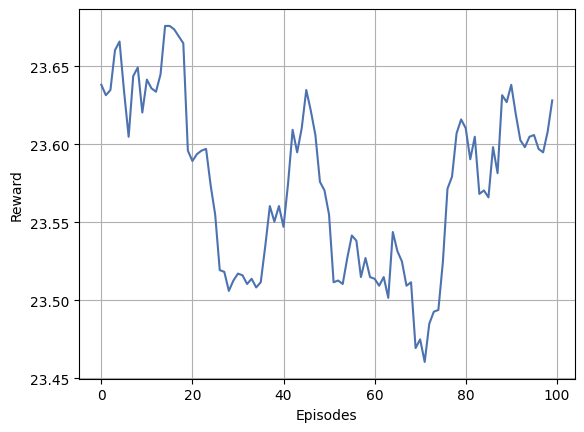

In [59]:
plot_rewards(ql_policy_rewards, 100)

We now have a trained Q-learning policy, that is a Q-table representing the action-state value function. Let's evaluate it.

In [ ]:
ql_eval_rewards, frames = evaluate_policy(policy=ql_policy, num_episodes=500)

 79%|███████▉  | 397/500 [00:26<00:05, 17.30it/s]

In [ ]:
eval_qlearning_policy_rwd = torch.tensor(ql_eval_rewards).mean()
print(f"Average evaluation reward\n")
print(f"Policy\t\t\tAvg. reward")
print(f"Random\t\t\t{eval_random_policy_rwd}")
print(f"Q-Learning Greedy\t{eval_qlearning_policy_rwd}")

In [ ]:
animate(frames)

How does the greedy agent perform wrt. the Random Policy?


## Epsilon-greedy agent

So, most of the time, a Q-learning agent fails to solve the task. One of the reasons for it is that the greedy policy with respect to a given estimate of $Q^\pi$ fails to *explore* the environment as needed. The problem is that our initialisation of the Q-function was "pessimistic" that means that once any of the actions is tried and is successful (by chance), the agent will keep selecting this action as it is "greedily" exploiting the Q-function estimate.

### ⭐ Exercise

One way to encourage exploration is to initialise the Q-funtion "optimistically", for example, with random values. Try modifying the agent above like this, what happens in this case? Hint: look at the line `self.q_values = torch.zeros((30, 30, 50, 50, env.action_space.n))`

In [ ]:
# Modify in the `__init__` function:
# self.q_values = torch.zeros((30, 30, 50, 50, env.action_space.n))

Optimistic initialisation might help us in this case, but a more general solution is to use **epsilon-greedy agent**. An $\epsilon$-greedy policy is a simple policy that at each time-step with probability $\epsilon$ will choose a random action instead of the greedy action. This ensures constant exploration  during learning.

### ⭐ Exercise

Update the QlearningAgent's policy to an $\epsilon$-greedy policy. Most things stays the same, but you need to modify `action_step` function to select the best action with probability $1-\epsilon$ and a random action with probability $\epsilon$. Note that agent takes parameters `epsilon` at the initialisation now.

In [ ]:
class ECQPolicy:
    def __init__(
        self,
        discount: float,
        lr: float,
        eps: float,
        n_actions: int
    ):
        """
        Implementation of the Q-Learning Policy
        Args:
            gamma: the discouting factor
            lr: the learning rate
            eps: the epsilon value
        """
        # -----------------------------------#
        # play with the q_table initialization (zeros, ones, randn)
        size = (30, 30, 50, 50, n_actions)
        self.q_values = torch.randn(size)
        # -----------------------------------#

        self.lr = lr
        self.eps = eps
        self.discount = discount

    def _get_q_idx(self, obs):
      """
      Convert state continuous values to discrete Q-Table bins
      Args:
        obs   torch.Tensor(4,)  observation tensor
      """
      # specific to CartPole
      discrete_state = obs / torch.tensor([0.25, 0.25, 0.01, 0.1]) + torch.tensor([15, 10, 1, 10])
      return tuple(discrete_state.int().tolist())

    def _get_q(self, obs):
      """
      Get Q-Table values
      Args:
        obs   torch.Tensor(4,)  observation tensor
      Returns:
              torch.Tensor(2, ) q-values for each action given obs
      """
      idx = self._get_q_idx(obs)
      return self.q_values[idx[0], idx[1], idx[2], idx[3]]

    def _set_q(self, obs, action, value):
      """
      Set Q-Table values
      Args:
        obs     torch.Tensor(4,)  observation tensor
        action  int               action index
        value   float             computed q-value
      """
      idx = self._get_q_idx(obs)
      self.q_values[idx[0], idx[1], idx[2], idx[3], action] = value


    def action_step(self, obs: int) -> int:
        """
        Epsilon-greedy policy
        Args:
          obs   torch.Tensor(4,)  observation tensor
        """
        if isinstance(obs, tuple): obs = torch.tensor(obs[0])
        elif not isinstance(obs, torch.Tensor): obs = torch.tensor(obs)
        # -----------------------------------#
        if torch.rand(1).item() < self.eps:
          return int(self._get_q(obs).argmax())
        else:
          return int(np.random.randint(n_actions))

        # -----------------------------------#


    def learner_step(
        self,
        obs: int,
        action: int,
        reward: float,
        next_obs: int,
    ):

        if not isinstance(obs, torch.Tensor):
              obs = torch.tensor(obs)
        if not isinstance(next_obs, torch.Tensor):
          next_obs = torch.tensor(next_obs)

        """Updates the Q-value of an action."""
        temporal_difference = (
            reward + self.discount * torch.max(self._get_q(next_obs)) - self._get_q(obs)[action]
        )
        self._set_q(
            obs=obs,
            action=action,
            value = self._get_q(obs)[action] + self.lr * temporal_difference
        )

In [ ]:
learning_rate = 0.5 # @param
discount_factor = 0.97 # @param
eps = 0.3 # @param

ql_policy = ECQPolicy(
    eps = eps,
    discount = discount_factor,
    lr = learning_rate,
    n_actions = env.action_space.n
)

In [ ]:
policy, train_rewards = train_policy(policy=ql_policy, num_episodes=1000)
eval_rewards, frames = evaluate_policy(policy=policy, num_episodes=100)

In [ ]:
plot_rewards(train_rewards, 100)

In [ ]:
eval_qlearning_policy_eps_decay_rwd = torch.tensor(eval_rewards).mean()
print(f"Average evaluation reward\n")
print(f"Policy\t\t\tAvg. reward")
print(f"Random\t\t\t{eval_random_policy_rwd}")
print(f"Q-Learning Greedy\t{eval_qlearning_policy_rwd}")
print(f"Q-Learning Eps-Greedy\t{eval_qlearning_policy_eps_decay_rwd}")

In [ ]:
animate(frames)

### ⭐ Exercise

Does the agent manage to solve the task? Experiment with the number of training episodes, the exploration rate $\epsilon$ and learning step.

What configuration allows you to achieve the highest score?

### ⭐ Bonus exercise

Try the Epsilon-Greedy Agent on the `Minigolf` environment. Fill the blanks to adapt the `ECQPolicy`.

In [ ]:
env = Minigolf()

In [ ]:
class MinigolfECQPolicy(ECQPolicy):
    def __init__(
        self,
        discount: float,
        lr: float,
        eps: float,
        n_bins: int
    ):
        """
        Implementation of the Q-Learning Policy
        Args:
            gamma: the discouting factor
            lr: the learning rate
            eps: the epsilon value
        """
        self.lr = lr
        self.eps = eps
        self.discount = discount

        N_b = n_bins
        self.dims = 3 # x, v, a
        self.q_values = torch.zeros([N_b] * self.dims)
        self.buckets = [
            torch.linspace(env.min_pos, env.max_pos, N_b),
            torch.linspace(env.min_friction, env.max_friction, N_b),
            torch.linspace(env.min_action, env.max_action, N_b),
        ]

    def _get_q_idx(self, obs):
      """
      Convert state continuous values to discrete Q-Table bins
      Args:
        obs   torch.Tensor(2,)  observation tensor
        Returns:
              List[int, int]    indices for discretized 2-dim observations
      """
      # discretizing continuous observations with torch.bucketize!
      return [torch.bucketize(obs[d], self.buckets[d]).item() for d in range(self.dims-1)]

    def _get_q(self, obs):
      """
      Get Q-Table values
      Args:
        obs   torch.Tensor(4,)  observation tensor
      Returns:
              torch.Tensor(2, ) q-values for each action given obs
      """
      idx = self._get_q_idx(obs)
      # -----------------------------------#
      # the action space as changed! Check len(idx)
      return self.q_values[idx[0], idx[1]]
      # -----------------------------------#

    def _set_q(self, obs, action, value):
      """
      Set Q-Table values
      Args:
        obs     torch.Tensor(4,)  observation tensor
        action  int               action index
        value   float             computed q-value
      """
      idx = self._get_q_idx(obs)
      # -----------------------------------#
      # this similar, but one more index is required
      self.q_values[idx[0], action] = value
      # -----------------------------------#

In [ ]:
# play with this params!
n_train_episodes = 1000 # @param
n_eval_episodes = 100 # @param
learning_rate = 0.5 # @param
discount_factor = 0.97 # @param
eps = 0.3 # @param
n_bins = 50 # @param


# -----------------------------------#
# ql_policy = MinigolfECQPolicy(
ql_policy = MinigolfECQPolicy(
    eps = eps,
    discount = discount_factor,
    lr = learning_rate,
    n_bins = n_bins
)
# -----------------------------------#

In [ ]:
policy, train_rewards = train_policy(policy=ql_policy, num_episodes=n_train_episodes)

In [ ]:
eval_rewards = evaluate_policy(policy=policy, num_episodes=n_eval_episodes)

In [ ]:
plot_rewards(train_rewards, 100)

And that's it! You should observe an upward trend in the reward curve over time. Feel free to play with the params to e.g. see the impact of the discretization parameter `N_b`. You can now move to the next section.

# 🥳 Congratulations on completing the first part of this tutorial, great job!!!

It is the most important part as it sets the foundations which would allow you to understand more advanced RL algorithms. Next, we will look into Deep RL: when RL algorithms are combined with neural network training.